In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread,imsave
import scipy.signal as ss
from skimage import measure
from matplotlib.path import Path
import pandas as pd
import seaborn as sns
from pywavesurfer import ws
from glob import glob
import os
from skimage.transform import downscale_local_mean

In [2]:
coordinates = []
for r in range(128):
    for c in range(128):
        coordinates.append([r,c])
coordinates = np.array(coordinates)

In [3]:
def isNaN(A):
    return A!=A

/Users/zhengj10/Desktop/230308/tif/230207_Plate_003_633.217_FOV_00006.tif


<Figure size 576x576 with 0 Axes>

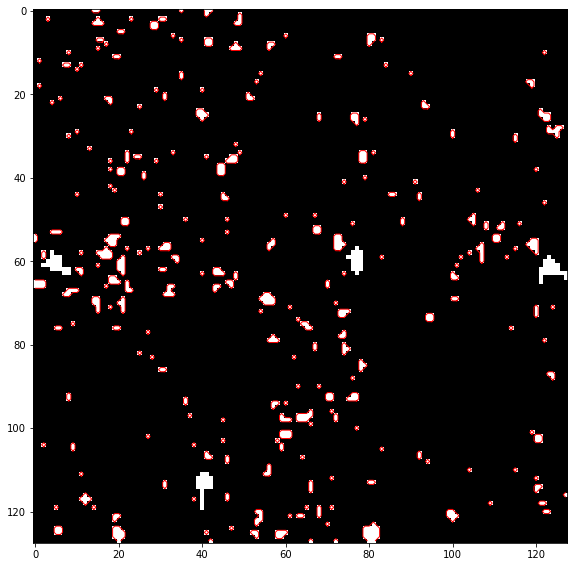

/var/folders/87/trl8ql4s7vj6fkdtrrkcwx6s0zb2d2/T/ipykernel_14864/2347637907.py:75: RuntimeWarning: invalid value encountered in true_divide
  dFF_all = (F - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
/var/folders/87/trl8ql4s7vj6fkdtrrkcwx6s0zb2d2/T/ipykernel_14864/2347637907.py:75: RuntimeWarning: invalid value encountered in true_divide
  dFF_all = (F - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
/var/folders/87/trl8ql4s7vj6fkdtrrkcwx6s0zb2d2/T/ipykernel_14864/2347637907.py:75: RuntimeWarning: invalid value encountered in true_divide
  dFF_all = (F - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)


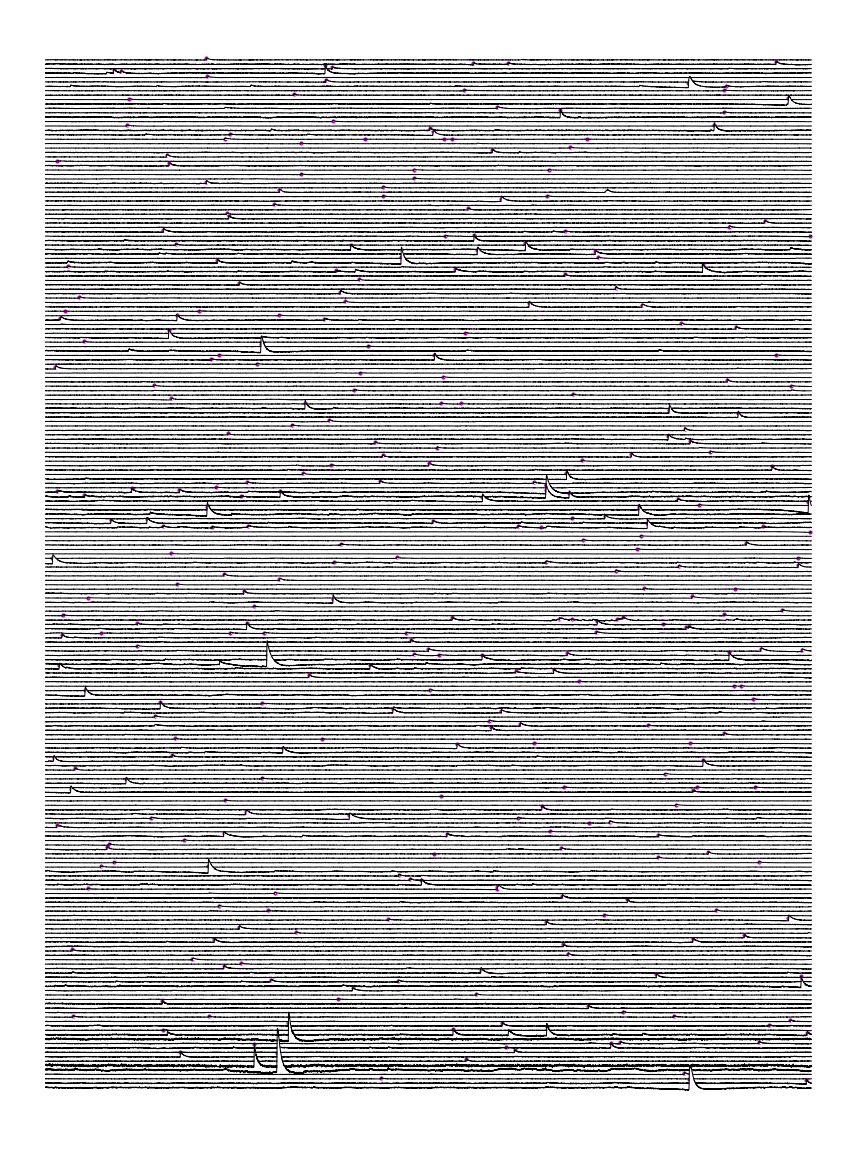

/Users/zhengj10/Desktop/230308/tif/230308_Plate_013_633.6787_FOV_00006.tif


<Figure size 576x576 with 0 Axes>

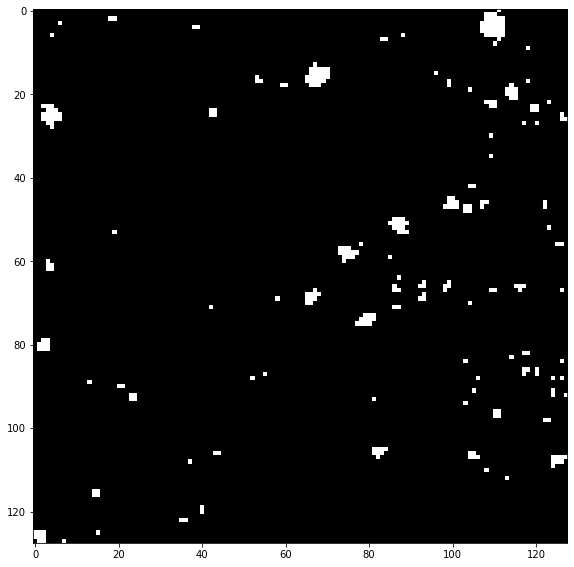

<Figure size 864x0 with 0 Axes>

In [65]:
imgPath = '/Users/zhengj10/Desktop'
dates = ['230308']
# imgPath = 'Y:\iGluSnFR_spontaneous_activity'
# date = 'cxd for Kaspar code'
for date in dates:
    Date = []
    Plate = []
    Construct = []
    FOV = []
    ROI = []
    ROI_no_pixels = []
    DFF = []
    Thre = []
    DFF_hp_filt = []
    Peak_idx = []

    Img_format = []
    Objective = []

    imgFiles = glob(os.path.join(imgPath,date,'tif')+'/*.tif')
    imgFiles = sorted(imgFiles)
    h5Files = glob(os.path.join(imgPath,date,'h5')+'/*.h5')
    h5Files = sorted(h5Files)
    thre = 1 # Exclude small ROIs

    for img_no in range(len(imgFiles)):
        imgFile = imgFiles[img_no]
        print(imgFile)

        imgData = imread(imgFile)
        imgData = downscale_local_mean(imgData,(1,4,4))
        F0 = imgData[0,:,:].astype('float16')
        Fb = np.min(imgData.astype('float16'))
        dFF = (imgData.astype('float16')-F0.astype('float16'))/(F0.astype('float16')-Fb)
        dFF_diff = np.diff(dFF, axis=0)
        plt.figure(figsize=[8,8])
        act_pix = (np.max(dFF_diff,axis=0)/np.std(dFF_diff[:50],axis=0))>7.5
        
        
#         bg = imgData[-1,:,:]>Fb+500
#         act_pix = bg*act_pix

        plt.figure(figsize=[8,8])
        plt.imshow(act_pix,cmap='gray',vmax=0.5)

        contours = measure.find_contours(act_pix, 0.5)
        for contour in contours:
            if contour.shape[0]>thre and contour.shape[0]<20:
                plt.plot(contour[:,1], contour[:,0], color = 'r',lw=1)
        plt.tight_layout()
#         plt.savefig(os.path.join(imgPath,date,'summary')+'\\ROI_%s.svg' %os.path.basename(imgFile)[:-4],format='svg')
        plt.show()
        plt.close()


        Fb = np.min(imgData[-1,:,:]).astype('float16')
        F0 = np.mean(imgData[:5,:,:],axis=0).astype('float16')

        rois = []
        for contour in contours:
            if contour.shape[0]>thre and contour.shape[0]<20:
                p = Path(contour)
                roi = p.contains_points(coordinates)
                roi = roi.reshape(128,128)
                rois.append(roi)

        fig = plt.figure(figsize=[12,len(rois)/15])
        y_shift = 1
        x = np.arange(1,imgData.shape[0]+1)
        for roi in range(len(rois)):

            offset = y_shift
            F = np.sum(rois[roi]*imgData,axis=1)
            F = np.sum(F,axis=1)
            dFF_all = (F - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
            if isNaN(dFF_all[0]) or np.std(dFF_all[:50])>0.15:
                continue
            b, a = ss.butter(2, 0.002, btype='high')
            dFF_hp_filt = ss.filtfilt(b, a, dFF_all,padlen=None)
            peaks,_ = ss.find_peaks(dFF_hp_filt,height=0.2)
            thre = np.max(np.diff(dFF_hp_filt))/np.std(dFF_hp_filt[:50])
            Thre.append(thre)

            Date.append(date)
            Plate.append(os.path.basename(imgFile).split('_')[1]+'_'+os.path.basename(imgFile).split('_')[2])
            Construct.append(os.path.basename(imgFile).split('_')[3])
            FOV.append(os.path.basename(imgFile).split('_')[-2]+'_'+os.path.basename(imgFile).split('_')[-1])
            ROI.append('roi_'+str(roi+1))
            ROI_no_pixels.append(np.sum(rois[roi]))
            DFF.append(dFF_all)
            DFF_hp_filt.append(dFF_hp_filt)
            Peak_idx.append(peaks)
            Img_format.append('.tif converted from .dcimg')
            Objective.append('63x oil; N/A: 1.4')
            
            plt.fill_between(x,dFF_hp_filt - offset, 0 - offset, zorder=y_shift+1, facecolor='w', edgecolor='w', lw=0, 
                             closed=True)
            plt.plot(x,dFF_hp_filt - offset,zorder=y_shift+1, color='k', lw=1)
            
            y = np.diff(dFF_hp_filt)
            p,_ = ss.find_peaks(y,height=5*np.std(y[:50]))
            plt.scatter(p+1,dFF_hp_filt[p+1]-offset,color='m',s=10)
            
            
            plt.axis('off')
            y_shift+=1            
        plt.tight_layout()
        sumPath = os.path.join(imgPath,date,'summary')
        if not os.path.exists(sumPath):
            os.makedirs(sumPath)
#         plt.savefig(sumPath+'\\dFF_traces_%s.svg' %os.path.basename(imgFile)[:-4],format='svg')
        plt.show()
        plt.close()


    df_new = pd.DataFrame({'Date':Date,'Plate':Plate,'Construct':Construct,'FOV':FOV,'ROI':ROI,
                           'ROI_no_pixels':ROI_no_pixels,'DFF':DFF,'DFF_hp_filt':DFF_hp_filt,'Thre':Thre,
                           'Peak_idx':Peak_idx,'Img_format':Img_format,'Objective':Objective,'Light_source':'Cyan',
                           'Power':'7%'})
    df_new.to_pickle(imgPath+'/%s_downscale_Mac.pkl' %date)

(1,)
(4,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(2,)
(1,)
(1,)
(1,)
(1,)
(1,)
(2,)
(1,)
(3,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(2,)
(2,)
(1,)
(3,)
(1,)
(1,)
(2,)
(1,)
(1,)
(2,)
(1,)
(1,)
(1,)
(1,)
(3,)
(1,)
(1,)
(2,)
(1,)
(1,)
(1,)
(1,)
(1,)
(2,)
(1,)
(1,)
(2,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(2,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


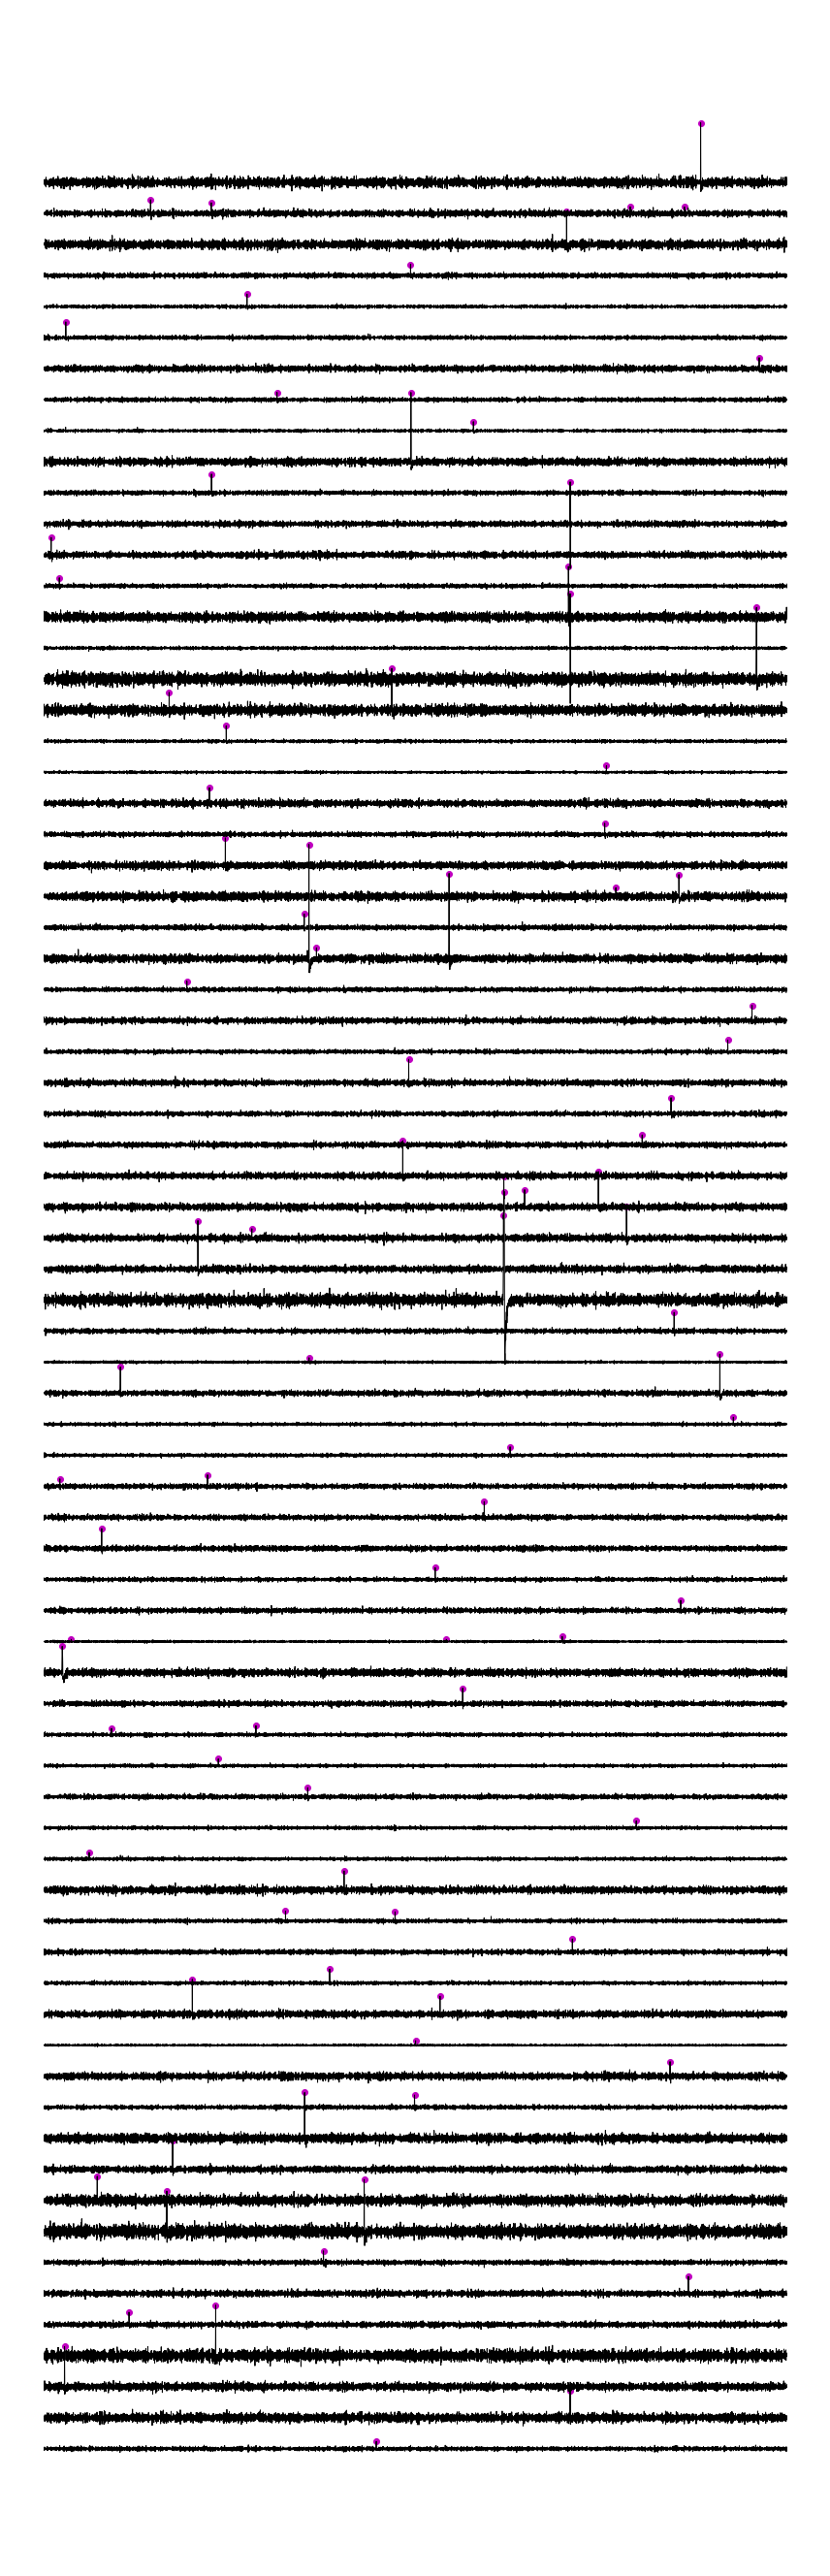

In [56]:
# df_new.Thre.median()
plt.figure(figsize=[12,len(df_new)/2])
for i,r in df_new.iterrows():
#     print(len(r['Peak_idx']))
    y = np.diff(r['DFF_hp_filt'])
    p,_ = ss.find_peaks(y,height=5*np.std(y[:50]))
    print(p.shape)
    x = np.arange(y.shape[0])
    plt.fill_between(x,y-i*2,-i*2,zorder=i+1,facecolor='w',edgecolor='w',lw=0,closed=True)
    plt.plot(x,y-i*2,-i*2,zorder=i+1,color='k',lw=1)
    plt.scatter(p,y[p]-i*2,color='m')
#         plt.scatter(peaks,dFF_all[peaks] - offset,color='m')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [47]:
# plt.hist(df_new.Thre,bins=100)
np.max(y)/np.std(y[:50])

8.560297139570176

In [48]:
np.std(y[:50])

0.05516363694494933

In [30]:
# plt.hist
df_plot = df_new[df_new['Thre']<7.5]
df_plot.index = np.arange(len(df_plot))
fig = plt.figure(figsize=[12,len(df_plot)/5])
for i,r in df_plot.iterrows():
    x = np.arange(len(r['DFF_hp_filt']))
    plt.fill_between(x,r['DFF_hp_filt']-i,0-i, zorder=i+1, facecolor='w', edgecolor='w', lw=0, 
                 closed=True)
    plt.plot(x,r['DFF_hp_filt']-i,zorder=i+1, color='k', lw=1)
    plt.axis('off')

<Figure size 864x0 with 0 Axes>